Camera projection
=============
Preliminary Python imports

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import re

Define a function that converts from a [bivector](https://en.wikipedia.org/wiki/Bivector), $r$ to a 3x3 rotation matrix, $\mathbf{R}$.

In [2]:
def logRotation (r) : 
    eps = 1e-6
    R = np.identity(3)
    rnp = np.array (r)
    R2 = rnp**2
    magR2 = R2.sum()
    magR = np.sqrt (magR2)

    alpha = 2 * magR
    
    if (magR2 > 10 * eps) :
        oneMinusCos_r2 = (1 - np.cos(alpha)) / magR2
        sin_r = np.sin(alpha) / magR
    else :
        # use McClauren
        oneMinusCos_r2 = 2 - 2*magR2/3
        sin_r = 2 - 4*magR2/3 + 8*magR2**2/30
        
    R[0,0] = 1 - (R2[1]+R2[2])*oneMinusCos_r2
    R[0,1] = rnp[0]*rnp[1]*oneMinusCos_r2 - rnp[2]*sin_r
    R[0,2] = rnp[0]*rnp[2]*oneMinusCos_r2 + rnp[1]*sin_r
    R[1,0] = rnp[0]*rnp[1]*oneMinusCos_r2 + rnp[2]*sin_r
    R[1,1] = 1 - (R2[0]+R2[2])*oneMinusCos_r2
    R[1,2] = (rnp[1]*rnp[2])*oneMinusCos_r2 - rnp[0]*sin_r
    R[2,0] = rnp[0]*rnp[2]*oneMinusCos_r2 - rnp[1]*sin_r
    R[2,1] = rnp[1]*rnp[2]*oneMinusCos_r2 + rnp[0]*sin_r
    R[2,2] = 1 - (R2[0]+R2[1])*oneMinusCos_r2
    return R    


Using homogeneous 3D spatial coordinate in mm, $x$, and homogenous 2D pixel coordinate, $p$, we can define a linear transformation between spatial and pixel coordinates, $p = \mathbf{C} x$. Nominally, $\mathbf{C}$ has 12 degrees of freedom. We can assume axial symmetry of the lens to reduce the dimensionality to 11 DOF. 

Given 6DOF to describe the position, $t$, and orientation of the camera, $r$, a rigid body transformation gives the homogeneous coordinate relative to the plane of the lens, in mm. The rotation matrix, $\mathbf{R}$, is given using the bivector, $r$.

$$ x_r = \begin{bmatrix} \mathbf{R} & t \end{bmatrix} x $$

Due to the axial symmetry of the lens, we may represent the mm to pixel scaling as a symmetric matrix plus scaling 3DOF to describe the pixel / mm scaling, $s$, and 2DOF to describe the center of the image sensor relative to the axis of the lens, $c$.

$$ p = \begin{bmatrix} s_{xx} & s_{xy} & c_x \\
                       s_{xy} & s_{yy} & c_y \\ 
                       0      &        & 1   \end{bmatrix} x_r $$
                       
Composing the linear transformations:

$$ \mathbf{C} = \begin{bmatrix} s_{xx} & s_{xy} & c_x \\
                                s_{xy} & s_{yy} & c_y \\ 
                                0      &        & 1   \end{bmatrix} \begin{bmatrix} \mathbf{R} & t \end{bmatrix} $$

The pixel coordinate, $p_i$, is homogeneous, representing a ray. To compute the pixel coordinate at the image sensor, $p'_i$, the coordinate is computed such that the third component equals 1.

$$ \begin{bmatrix} p'_{i, x} \\ p'_{i, y} \\ 1 \end{bmatrix} = \frac{p_i}{p_{i, z}} $$

Camera calibration is then a minimization of the difference between predicted pixels and measured pixels for a given set of point / pixel pairs. The calibration of each camera can be computed independently if the locations are known.

In [3]:
def single_camera (r, t, s, c) :
    R = np.zeros ((3, 4))
    R[:3,:3] = logRotation (r)
    R[:3,3] = t
    S = np.zeros ((3,3))
    S[0,0] = s[0]
    S[1,1] = s[1]
    S[2,2] = 1
    S[0,1] = s[2]
    S[1,0] = s[2]
    S[0,2] = c[0]
    S[1,2] = c[1]
    S[2,0] = 0
    S[2,1] = 0
    return np.dot (S, R)

A linear transfomration matrix, $\mathbf{C}_i$, exists for each camera, $i$. Pixel coordinates for $n$ cameras can then be concatenated by concatenating camera matrices.

$$ \begin{bmatrix} p_0 \\ p_1 \\ \vdots \\ p_{n-1} \end{bmatrix} = \begin{bmatrix} C_0 \\ 
C_1 \\ \vdots \\ C_{n-1} \end{bmatrix} x $$

In [4]:
def create_cameras (p, n) :
    C = np.zeros ((3*n, 4))
    for i in range (n) :
        r = p[(0+11*i):(3+11*i)] 
        t = p[(3+11*i):(6+11*i)]
        s = p[(6+11*i):(9+11*i)]
        c = p[(9+11*i):(11+11*i)]
        C[(0+3*i):(3+3*i),:] = single_camera(r,t,s,c)
    return C

Camera calibration
===========
Load the calibrated camera parameters from 'cal3d_3cam_2mm_final.csv'


In [5]:
with open ('cal3d_4cam_2mm_final.csv') as cF:
    p = [ float (n[0]) for n in list (csv.reader (cF))]

C = create_cameras (p, 4)

Solving for a coordinate in a multicamera setup
===============================================
For a given camera matrix, $\mathbf{C_i}$, we can partition it into four submatrices.

$$ \mathbf{C_i} = \begin{bmatrix} {AA}_i & {AB}_i \\ {BA}_i & {BB}_i \end{bmatrix} $$

such that for $ \begin{bmatrix} x' \\ 1 \end{bmatrix} = x $

$$ \begin{bmatrix} p_{i,x} \\ p_{i,y} \end{bmatrix} = {AA}_i x' + {AB}_i $$
$$ p_{i,z} = {BA}_i x' + {BB}_i $$

Since $ \begin{bmatrix} p'_{i,x} \\ p'_{i,y} \end{bmatrix} p_{i,z}  = \begin{bmatrix} p_{i,x} \\ p_{i,y} \end{bmatrix} $, we can write the following equality.

$$ \begin{bmatrix} p'_{i,x} \\ p'_{i,y} \end{bmatrix} \left( {BA}_i x' + {BB}_i \right) = {AA}_i x' + {AB}_i $$

rearranging so that the equation is in the form $ \mathbf{A} x = b $ 

$$ \left( {AA}_i - \begin{bmatrix} p'_{i,x} \\ p'_{i,y} \end{bmatrix} {BA}_i \right) x'  = \begin{bmatrix} p'_{i,x} \\ p'_{i,y} \end{bmatrix} {BB}_i - {AB}_i $$

Then concatenating $n$ cameras of image data, where $n > 1$, we create an overdetermined system such that we can solve for $x'$ as the least-squares solution. $x' = {(A^T A)}^{-1} A^T b $

$$ \left( \begin{bmatrix} AA_0 \\ AA_1 \\ \vdots \\ AA_{n-1} \end{bmatrix} - 
   \begin{bmatrix} p'_{0,x} & 0 & \cdots & 0 \\ 
                   p'_{0,y} & 0 & \cdots & 0 \\
                   0 & p'_{1,x} & \cdots & 0 \\
                   0 & p'_{1,y} & \cdots & 0 \\
                   \vdots & \vdots & \ddots & \vdots \\
                   0 & 0 & \cdots & p'_{n-1,x} \\
                   0 & 0 & \cdots & p'_{n-1,y} \\ \end{bmatrix} 
    \begin{bmatrix} {BA}_0 \\ {BA}_1 \\ \vdots \\ {BA}_{n-1} \end{bmatrix} \right) x' = 
    \begin{bmatrix} p'_{0,x} & 0 & \cdots & 0 \\ 
                   p'_{0,y} & 0 & \cdots & 0 \\
                   0 & p'_{1,x} & \cdots & 0 \\
                   0 & p'_{1,y} & \cdots & 0 \\
                   \vdots & \vdots & \ddots & \vdots \\
                   0 & 0 & \cdots & p'_{n-1,x} \\
                   0 & 0 & \cdots & p'_{n-1,y} \\ \end{bmatrix} 
    \begin{bmatrix} {BB}_0 \\ {BB}_1 \\ \vdots \\ {BB}_{n-1} \end{bmatrix} - 
    \begin{bmatrix} AB_0 \\ AB_1 \\ \vdots \\ AB_{n-1} \end{bmatrix}$$

In [6]:
def camera_coord (fp, tp, rp, lp, fN, useFp, useTp, useRp, useLp) :
    checkUse = [useFp, useRp, useLp]
    if checkUse== [[False], [False], [False]]: return [] #if non can be used or only 1 view can be used (not including Top)then skip
    if checkUse== [[True], [False], [False]]: return []
    if checkUse== [[False], [True], [False]]: return []
    if checkUse== [[False], [False], [True]]: return []
    
    cF = open (fN)
    p = [ float (n[0]) for n in list (csv.reader (cF))]
    C = create_cameras (p, 4)
    CAA = np.zeros ((8,3)) #6,3
    CAB = np.zeros ((8,1)) #6,1
    CBA = np.zeros ((4,3)) #3,3
    CBB = np.zeros ((4,1)) #3,1
    CAA[0:2,:] = C[0:2,:3]
    CAA[2:4,:] = C[3:5,:3]
    CAA[4:6,:] = C[6:8,:3]
    CAA[6:8,:] = C[9:11,:3]
    CAB[0:2,0] = C[0:2,3]
    CAB[2:4,0] = C[3:5,3]
    CAB[4:6,0] = C[6:8,3]
    CAB[6:8,0] = C[9:11,3]
    CBA[0,:] = C[2,:3]
    CBA[1,:] = C[5,:3]
    CBA[2,:] = C[8,:3]
    CBA[3,:] = C[11,:3]
    CBB[0] = C[2,3]
    CBB[1] = C[5,3]
    CBB[2] = C[8,3]
    CBB[3] = C[11,3]
    num_pts = fp.shape[1]
    coord = np.zeros ((3,num_pts))
    for i in range (num_pts) :
        # Compute linear solution
        tm = np.zeros((8,4)) #6,3
        tm[0:2,0] = fp[:,i]+1
        tm[2:4,1] = tp[:,i]+1
        tm[4:6,2] = rp[:,i]+1
        tm[6:8,3] = lp[:,i]+1
        A = CAA - np.dot (tm, CBA)
        B = np.dot (tm, CBB) - CAB
        numInUse = 0
        if (useFp[i]):
            numInUse += 1
        if (useTp[i]):
            numInUse += 1
        if (useRp[i]):
            numInUse += 1
        if (useLp[i]):
            numInUse += 1
        useA = np.zeros((2*numInUse,3))
        useB = np.zeros((2*numInUse,1))
        currRow = 0
        if (useFp[i]):
            useA[currRow:(currRow+2),:] = A[0:2,:]
            useB[currRow:(currRow+2),:] = B[0:2,:]
            currRow += 2
        if (useTp[i]):
            useA[currRow:(currRow+2),:] = A[2:4,:]
            useB[currRow:(currRow+2),:] = B[2:4,:]
            currRow += 2
        if (useRp[i]):
            useA[currRow:(currRow+2),:] = A[4:6,:]
            useB[currRow:(currRow+2),:] = B[4:6,:]
            currRow += 2
        if (useLp[i]):
            useA[currRow:(currRow+2),:] = A[6:8,:]
            useB[currRow:(currRow+2),:] = B[6:8,:]
            currRow += 2
        ttt = np.linalg.solve (np.dot (useA.transpose(), useA), np.dot (useA.transpose(), useB))
        
        coord[:,i] = ttt[:,0]
        
    return coord

In [26]:
front=np.array([[551.2247191,1102.011236]],dtype=np.float64).transpose()
top=np.array([[225.5189873,833.4556962]],dtype=np.float64).transpose()
rear=np.array([[431.4539474,967.3026316]],dtype=np.float64).transpose()
live=np.array([[425.4767442,1027.511628]],dtype=np.float64).transpose()
curdir= os.getcwd()
calFile= os.path.join(curdir,'cal3d_4cam_2mm_final.csv')
camera_coord(front,top,rear,live,calFile,[True],[True],[True],[True])

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\HoangT04\\Documents\\deform\\HD_data\\Sample60_Runs5to6\\Run 6\\cal3d_4cam_2mm_final.csv'

Processing views from cameras
====

Electrodes are identified and pixel coordinates stored in a csv file: ProcRun.csv. Image files have been cropped, so the crop coordinate must be taken into account.

***
__From:__ Hill, Tony 
__Sent:__ Monday, January 08, 2018 10:38 AM
__To:__ Lundquist, Eric; Belk, Paul
__Subject:__ RE: HD status

I can start looking at the 3-camera data before Thuy gets back. We can decide from there how much more data is needed.

I have done the camera calibration and am ready to start modifying the scripts that she’s been using. One thing that I’m missing is the top-left pixel coordinate of the crop for each camera. Can you look this up and send it to me?

Thanks,
Tony

-----------------
__From:__ Lundquist, Eric 
__Sent:__ Monday, January 08, 2018 10:51 AM
__To:__ Hill, Tony <tony.hill@abbott.com>; Belk, Paul <paul.belk@abbott.com>
__Subject:__ RE: HD status


Upper Left Pixel Coordinates:

Front: (283,471) = 4

Rear: (152,445) = 39

Top: (4,168) = 75
***

Something in this does not add up. The original images are 1600 x 1200 (width x height). The cropped front image is 908 x 744. Adding the top right coordinate to the cropped size puts the lower right coordinate of the cropped image at (x = 1191, y = 1215). This is outside the original dimensions.

In [27]:
#picking which view to use, if any coordinates is 0 then don't use that view
def pickView(front,rear,live): #front and rear are xy coordinates    
    useFront=[True]
    useRear=[True]
    useLive=[True]
    if live[0][0]==0 or live[0][1]==0: #Live is 0
        useLive=[False]
    if front[0][0] ==0 or front[0][1]==0: #Front is 0
        useFront=[False]
    if rear[0][0]==0 or rear[0][1]==0: #Rear is 0
        useRear=[False]
    return useFront, useRear, useLive

In [28]:
#use Rear when Rear has all 16 good paddle electrodes and Front has less good electrodesgiven df and row
import math
def allRear(df,row):
    rear=[]
    front=[]
    distances= []
    distances2= []
    for sN in range (4):
        for eN in range (4) :
            rear= rear+ ["rs{}e{}{}".format (sN+1, eN+1,c) for c in 'yx' ] 
            front= front+ ["fs{}e{}{}".format (sN+1, eN+1,c) for c in 'yx' ]
           
    #count bad rear and front electrodes        
    rcount=0 
    fcount=0
    for elec in rear:
        if df.loc[row,elec]==0:
            rcount=rcount+1
    for elec in front:
        if df.loc[row,elec]==0:
            fcount=fcount+1
            
    if rcount==0 and fcount>15: #useRear if rear has all good electrodes and front has more than 8 bad electrodes
        return 1
    else:
        return 0

In [29]:
def outlierCheckFront(data):  #checking outlier for Front images
    xcol=[]
    ycol=[]
    for sN in range (4) : 
        for eN in range (4) :
            #getting column names:
            xcol= xcol+["fs{}e{}{}".format (sN+1, eN+1,'x')]
            ycol= ycol+["fs{}e{}{}".format (sN+1, eN+1,'y')]
    rowOut=[]
    elecOut=[]
    for row in range(len(df)): 
        frontx=[]
        fronty=[]               
        for sN in range (4) :  #getting row data
            for eN in range (4) :
                frontx= frontx+ [data.loc[row,"fs{}e{}{}".format (sN+1, eN+1,'x')]]
                fronty= fronty+ [data.loc[row,"fs{}e{}{}".format (sN+1, eN+1,'y')]]
        # location of shaft electrode 18 (use as x lower bound) :
        #ylower= data.loc[row,'fshft2x'] #this is right, don't change xy
        
        #excluding outlier that are far away
        inOut= np.zeros(16) 
        for n in range(len(frontx)):
            if frontx[n]==0 or fronty[n]==0:
                frontx[n]=700
                fronty[n]=1000
            if frontx[n]> 400 and frontx[n]<1100 and fronty[n]>390 and fronty[n]<1200:
                inOut[n]= 1 #good electrode
            
            else: #bad electrode
                print(row, 'FRONT', n ,frontx[n],fronty[n])
                rowOut= rowOut+[row]      
                elecOut= elecOut+[n]
    return rowOut, elecOut

In [30]:
def outlierCheckRear(data):  #checking outlier for Rear images
    xcol=[]
    ycol=[]
    for sN in range (4) : 
        for eN in range (4) :
            #getting column names:
            xcol= xcol+["rs{}e{}{}".format (sN+1, eN+1,'x')]
            ycol= ycol+["rs{}e{}{}".format (sN+1, eN+1,'y')]
    rowOut=[]
    elecOut=[]
    for row in range(len(df)): 
        rearx=[]
        reary=[]               
        for sN in range (4) :  #getting row data
            for eN in range (4) :
                rearx= rearx+ [data.loc[row,"rs{}e{}{}".format (sN+1, eN+1,'x')]]
                reary= reary+ [data.loc[row,"rs{}e{}{}".format (sN+1, eN+1,'y')]]
  
        #excluding outlier that are far away
        inOut= np.zeros(16) 
        for n in range(len(rearx)):
            if rearx[n]==0 or reary[n]==0:
                rearx[n]= 950
                reary[n]= 600
            if rearx[n]>300 and rearx[n]<1500 and reary[n]>200 and reary[n]<1370:
                inOut[n]= 1 #good electrode
            else: #bad electrode
                print(row,'REAR', n ,rearx[n],reary[n])
                inOut[n]= 0
                rowOut= rowOut+[row]      
                elecOut= elecOut+[n]
    return rowOut, elecOut

In [117]:
n

28

# EXECUTE BOX BELOW FOR 2D TO 3D CONVERSION OF ALL DATA IN THE SPECIFIED DIRECTORY

In [40]:
#Note: xy are switched for a reason, leave it there!

#os.chdir('Q:\\AF R&D\\AR&T Active Projects\\Hybrid localization\\Design\\Mechanical modeling\\Advisor HD\\NewData') #change current working folder
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data')
curdir= os.getcwd() #change current working directory 
calFile= os.path.join(curdir,'cal3d_4cam_2mm_final.csv') #calibration data
#os.chdir("Q:\\AF R&D\\AR&T Active Projects\\Hybrid localization\\Design\Mechanical modeling\\Advisor HD\\3 Cams data")
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data\\Sample65_Runs11to18\\Run 11')

#Go through all the files in the current directory:
for root, dir, files in os.walk("."): #walk the directory tree
    if 'ProcRunWithLive.csv' in files: #find the ProcRun
        if not 'OldProcRunWithLive1.csv' in files: continue
        ProcPath= os.path.join(root, 'ProcRunWithLive.csv')
        print(root)
        dataframe = pd.read_csv (ProcPath) #create a new panda frame based on ProcRun

        df= dataframe #.drop(dataframe.index[last_row]) #Fixed
        
        #Check for Outliers in Front and Rear images:
        rowOutFront, elecOutFront= outlierCheckFront(df)
        rowOutRear, elecOutRear= outlierCheckRear(df)
        
        #Go through each electrode in each row:
        for row in range (len (df)) :
            #checkRear= allRear(df,row) #see if Rear has all 16 good paddle elec and Front has less good elec
            for sN in range (4) : #struts electrodes
                for eN in range (4) :                       
                    if not "ts2e1x" in df.columns:             
                        top = [ [ df.loc[row, "ts1e{}{}".format (eN+1, c)] for c in "yx" ] ]                      
                    else:
                        top = [ [ df.loc[row, "ts{}e{}{}".format (sN+1, eN+1, c)] for c in "yx" ] ]
                    rear= [ [ df.loc[row, "rs{}e{}{}".format (sN+1, eN+1, c)] for c in "yx" ] ]
                    front = [ [ df.loc[row, "fs{}e{}{}".format (sN+1, eN+1, c)] for c in "yx" ] ] 
                    live = [ [ df.loc[row, "ls{}e{}{}".format (sN+1, eN+1, c)] for c in "yx" ] ]                     
                    
                    # Determine which views to use:
                    useTop=[False]  
                    useFront, useRear, useLive= pickView(front,rear,live)

                    elecNum= sN*4+eN
                    if row in rowOutFront and elecNum in elecOutFront:
                        useFront=[False]
                    if row in rowOutRear and elecNum in elecOutRear:
                        useRear=[False]                      
                    # 2D to 3D coordinates conversion:
                    c3d = camera_coord (np.array (front).transpose(), np.array (top).transpose(), np.array(rear).transpose(), np.array(live).transpose(),calFile, useFront, useTop, useRear, useLive)                    
                    if not len (c3d):
                        continue
                    df.loc[row, "e{}x".format (sN*4+eN+1)] = c3d[0,0]
                    df.loc[row, "e{}y".format (sN*4+eN+1)] = c3d[1,0]
                    df.loc[row, "e{}z".format (sN*4+eN+1)] = c3d[2,0]
                    
                    
                    #print("e{}x".format (sN*4+eN+1),useTop, useFront, useRear, useLive, np.array(c3d).transpose())
                    #print(front, rear, live)
                    
            for eN in range (2) : #shaft electrodes
                front = [ [ df.loc[row, "fshft{}{}".format (eN+1, c)] for c in "yx" ] ]
                top = [ [ df.loc[row, "tshft{}{}".format (eN+1, c)] for c in "yx" ] ]
                rear= [ [ df.loc[row, "rshft{}{}".format (eN+1, c)] for c in "yx" ] ]  
                live= [ [ df.loc[row, "lshft{}{}".format (eN+1, c)] for c in "yx" ] ]                              
                
                # Determine which views to use:
                if not top==0:
                    useTop=[True] 
                else: useTop==[False]
                useFront, useRear, useLive= pickView(front,rear,live)
                    
                # 2D to 3D conversion:
                c3d = camera_coord (np.array (front).transpose(), np.array (top).transpose(),np.array(rear).transpose(), np.array(live).transpose(),calFile, useFront, useTop, useRear, useLive)
                if not len (c3d):
                    continue
                df.loc[row, "Se{}x".format (eN+1)] = c3d[0,0]
                df.loc[row, "Se{}y".format (eN+1)] = c3d[1,0]
                df.loc[row, "Se{}z".format (eN+1)] = c3d[2,0]
                
                #print("Se{}z".format (eN+1),useTop, useFront, useRear, useLive, np.array(c3d).transpose())
            #print( )
        df.to_csv ("{}/ProcRun3D_WithLive.csv".format(root), index=False)
        df.to_excel("{}/ProcRun3D_WithLive.xls".format(root), index=False)
print('done!')            


.
done!


# Rearranging Images and Data 

Becareful! This will shuffle data in df

In [31]:
#when numbering is 3 digit based, the next number to 999 is 000, which messed up the order
#this will rearrage the row given the column of data that needs to be reaaraged
def Rearrange(df,col,rowNum):
    a= int(rowNum) #where 2 digit names turns to 3 digit names ex: 028 to 993
    df2= pd.DataFrame()
    #creating df2 which is the first chunk of data from image 000 to where images 99# begin
    df2[col]= df[col][0:a+1] #chunk1
    if col.startswith('Front'): whichCol= 'f'
    elif col.startswith('Rear') : whichCol='r'
    elif col.startswith('Live') : whichCol='l'
    elif col.startswith('Top') : whichCol='t'
    else: 
        print('column name given is not Front, Rear or Live. Check again!')
        return []
    for sN in range (4) : #struts electrodes
        for eN in range (4) :
            for c in 'yx':
                if whichCol=='t' and sN>0: continue
                else:
                    colName= "{}s{}e{}{}".format (whichCol, sN+1, eN+1, c)
                    df2[colName]= df[colName][0:a+1]
    for eN in range (2) : #shaft electrodes
        for c in 'yx':
            colName= "{}shft{}{}".format (whichCol, eN+1, c)
            df2[colName]= df[colName][0:a+1]
    #add to end, shift up and drop extra rows:
    #add
    df3= df.append(df2, ignore_index=True) #add 1st chunk (000 to 9..) to end of df
    #shift
    df3[col]= df3[col].shift(-a-1)
    for sN in range (4) : #struts electrodes
        for eN in range (4) :
            for c in 'yx':
                if whichCol=='t' and sN>0: continue
                colName= "{}s{}e{}{}".format (whichCol, sN+1, eN+1, c)
                df3[colName]= df3[colName].shift(-a-1) #shift df up to make image 9.. be the first row
    for eN in range (2) : #shaft electrodes
        for c in 'yx':
            colName= "{}shft{}{}".format (whichCol,eN+1, c)
            df3[colName]= df3[colName].shift(-a-1) #shift df up to make image 9.. be the first row
    #drop 
    df3.drop(df3.tail(a+1).index,inplace=True) #drop the extra rows at the end
    return df3

In [35]:
#looking for files with mixed up images
#if found, then open up ProcRun csv and append the first set from 000 to 9.. to the end of the column and then shift up
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data')
tempDir= 'C:\\Users\\HoangT04\\Documents\\deform\\HD_data\\Rearrage'
from os import listdir
ProcFile= 'ProcRunWithLive - Copy.csv'
for root, dir, files in os.walk("."): #walk the directory tree
    picFiles={}
    if ProcFile in files:
        ProcPath= os.path.join(root, ProcFile)
        df = pd.read_csv (ProcPath) #create a new panda frame based on ProcRun
        checkView=0 #how many view is messed up
        
        #Front
        frontPics= os.path.join(root, 'Front')
        picFiles['Front_seq']= [(f.split('_')[0])[5:] for f in listdir(frontPics)] #number sequence in Front images
        if '999' in picFiles['Front_seq'] and '000' in picFiles['Front_seq']:
            for f in picFiles['Front_seq']:
                if int(f) <500: a= int(f) #there two digit number turns to 3 digit numbers
            print(root, a, 'Front')
            ProcPath= os.path.join(root, ProcFile)
            df = pd.read_csv (ProcPath)
            dfCor= Rearrange(df, 'Front',a) #corrected df
            dfCor.to_csv("{}/ProcRunWithLive.csv".format(root), index=False) 
            checkView= checkView+1
            #dfCor.to_excel("{}/Test1.xls".format(tempDir), index=False)
        #Live
        LivePics= os.path.join(root, 'Live')
        picFiles['Live_seq']= [(f.split('_')[0])[4:] for f in listdir(LivePics)] #number sequence in Front images
        if '999' in picFiles['Live_seq'] and '000' in picFiles['Live_seq']:
            for f in picFiles['Live_seq']:
                if int(f) <500: a= f 
            print(root, a, 'Live')
            if checkView>0: 
                df= dfCor
            else:
                ProcPath= os.path.join(root, ProcFile)
                df = pd.read_csv (ProcPath)
            dfCor= Rearrange(df, 'Live',a)
            dfCor.to_csv("{}/ProcRunWithLive.csv".format(root), index=False) 
            checkView=checkView+1
        #Top
        TopPics= os.path.join(root, 'Top')
        picFiles['Top_seq']= [(f.split('_')[0])[3:] for f in listdir(TopPics)] #number sequence in Front images
        if '999' in picFiles['Top_seq'] and '000' in picFiles['Top_seq']:
            for f in picFiles['Top_seq']:
                if int(f) <500: a= f 
            print(root, a, 'Top')
            if checkView>0: df= dfCor
            else:
                ProcPath= os.path.join(root, ProcFile)
                df = pd.read_csv (ProcPath)
            dfCor= Rearrange(df, 'Top',a)
            dfCor.to_csv("{}/ProcRunWithLive.csv".format(root), index=False)
            checkView=checkView+1
        #Rear
        RearPics= os.path.join(root, 'Rear')
        picFiles['Rear_seq']= [(f.split('_')[0])[4:] for f in listdir(RearPics)] #number sequence in Front images
        if '999' in picFiles['Rear_seq'] and '000' in picFiles['Rear_seq']:
            for f in picFiles['Rear_seq']:
                if int(f) <500: a= f 
            print(root, a, 'Rear')
            if checkView>0: 
                df= dfCor
            else:
                ProcPath= os.path.join(root, ProcFile)
                df = pd.read_csv (ProcPath)
            dfCor= Rearrange(df, 'Rear',a)
            dfCor.to_csv("{}/ProcRunWithLive.csv".format(root), index=False) 
            
print('done!') 

.\Sample16_Runs15to25\Run 16 027 Rear
.\Sample16_Runs15to25\Run 17 37 Front
.\Sample16_Runs1to14\Run 2 2 Front
.\Sample16_Runs1to14\Run 2 065 Rear
.\Sample53_Runs1to9\Run 2 039 Rear
.\Sample53_Runs1to9\Run 3 49 Front
.\Sample53_Runs1to9\Run 5 039 Live
.\Sample53_Runs1to9\Run 5 019 Top
.\Sample60_Runs5to6\Run 6 040 Rear
.\Sample60_Runs7to8\Run 7 50 Front
.\Sample65_Runs11to18\Run 14 027 Rear
.\Sample65_Runs11to18\Run 15 37 Front
.\Sample65_Runs11to18\Run 18 064 Live
.\Sample65_Runs11to18\Run 18 044 Top
.\Sample65_Runs1to7\Run 1 020 Rear
.\Sample65_Runs1to7\Run 2 30 Front
.\Sample69_Runs3to10\Run 10 071 Live
.\Sample69_Runs3to10\Run 10 051 Top
.\Sample69_Runs3to10\Run 7 5 Front
.\Sample69_Runs3to10\Run 7 071 Rear
done!


Reproject coordinates onto images
==================
First load camera parameters

In [7]:
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data')
with open ('cal3d_4cam_2mm_final.csv') as cF:
    p = [ float (n[0]) for n in list (csv.reader (cF))]

C = create_cameras (p, 4)

In [8]:
def giveCaldots(root,row,df,v):
    f= plt.figure()
    ImName= df.loc[row,v]
    ImDir= os.path.join(root, v, ImName)
    im= mpimg.imread(ImDir)
    im_plot= plt.imshow(im)
    plt.title('{} camera'.format(v))
    im_plot.set_cmap('gray')
    for elec in range(18):
        if elec>15: #shaft electrodes
            x= df.loc[row,'Se{}x'.format(elec-15)]
            y= df.loc[row,'Se{}y'.format(elec-15)]
            z= df.loc[row,'Se{}z'.format(elec-15)]
        else:#paddle electrodes
            x= df.loc[row,'e{}x'.format(elec+1)]
            y= df.loc[row,'e{}y'.format(elec+1)]
            z= df.loc[row,'e{}z'.format(elec+1)]
        coord = np.array([[x],[y],[z]],dtype=np.float64)
        pix_hom= pix_hom = np.dot(C, np.append(coord,1))
        if v=='Front':
            front_pix = pix_hom[0:2]/pix_hom[2] - 1
            front_caldots = plt.plot(front_pix[0],front_pix[1],'r.')
        elif v=='Top':
            top_pix = pix_hom[3:5]/pix_hom[5] - 1
            top_caldots = plt.plot(top_pix[0],top_pix[1],'r.')
        elif v=='Rear':
            rear_pix = pix_hom[6:8]/pix_hom[8] - 1
            rear_caldots = plt.plot(rear_pix[0],rear_pix[1],'r.')
        elif v=='Live':
            live_pix = pix_hom[9:11]/pix_hom[11] - 1
            live_caldots = plt.plot(live_pix[0],live_pix[1],'r.')
    f.savefig(root+'//ProjectedImages//{}{}.png'.format(v,row))

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.ioff()
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data')

Proc3D= 'ProcRun3D_WithLive.csv'
for root, dir, files in os.walk("."): #walk the directory tree
    if Proc3D in files and 'ProjectedImages' not in os.listdir(root):
        print(root)
        directory=os.path.join(root,'ProjectedImages') #make new folder 
        if not os.path.exists(directory):
            os.makedirs(directory)
        ProcPath= os.path.join(root, Proc3D)
        df = pd.read_csv (ProcPath)
        for row in range(len(df)):
            for v in 'Front Rear Top Live'.split( ):
                giveCaldots(root,row,df,v)
                plt.close('all')

.\Sample65_Runs8to10\Run 8
.\Sample66_Runs1to2\Run 1
.\Sample66_Runs1to2\Run 2
.\Sample69_Runs3to10\Run 10
.\Sample69_Runs3to10\Run 3
.\Sample69_Runs3to10\Run 4
.\Sample69_Runs3to10\Run 7
.\Sample69_Runs3to10\Run 8
.\Sample69_Runs3to10\Run 9


In [8]:
os.listdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data\\Sample49_Runs3to4\\Run 4')

['1.csv',
 'Front',
 'FullRun.csv',
 'Live',
 'OldProcRunWithLive1.csv',
 'ProcRun.csv',
 'ProcRun3D.csv',
 'ProcRun3D.xls',
 'ProcRun3D_old.csv',
 'ProcRun3D_old.xls',
 'ProcRun3D_old2.csv',
 'ProcRun3D_old2.xls',
 'ProcRun3D_WithLive.csv',
 'ProcRun3D_WithLive.xls',
 'ProcRunWithLive.csv',
 'ProjectedImages',
 'Rear',
 'Top']

Then, compute pixel coordinates in each of the cameras.

In [7]:
#coord = np.array([[12.25258505],[49.94716879],[6.853292571]],dtype=np.float64)
#49.75267826	6.608352317	5.517891798
coord = np.array([[49.75267826],[6.608352317],[5.517891798]],dtype=np.float64)
pix_hom = np.dot(C, np.append(coord,1))
# subtract 1 because python is 0-based, C is from MATLAB, which is 1-based
front_pix = pix_hom[0:2]/pix_hom[2] - 1
top_pix = pix_hom[3:5]/pix_hom[5] - 1
rear_pix = pix_hom[6:8]/pix_hom[8] - 1
live_pix = pix_hom[9:11]/pix_hom[11] - 1

In [11]:
pix_hom

array([  2.80061643e+05,   1.39480664e+05,   2.53925186e+02,
         1.87479026e+05,   5.42580554e+04,   2.26767918e+02,
         1.53227365e+05,   5.51781986e+04,   1.44893134e+02,
         1.94632559e+05,   8.33210814e+04,   1.88445114e+02])

In [54]:
print(front_pix, rear_pix, live_pix)

[ 1045.5691847   582.3927381] [ 1080.3153794    455.22278692] [ 1055.16393535   514.97423516]


Plot pixels on top of images to check reprojection

<IPython.core.display.Javascript object>


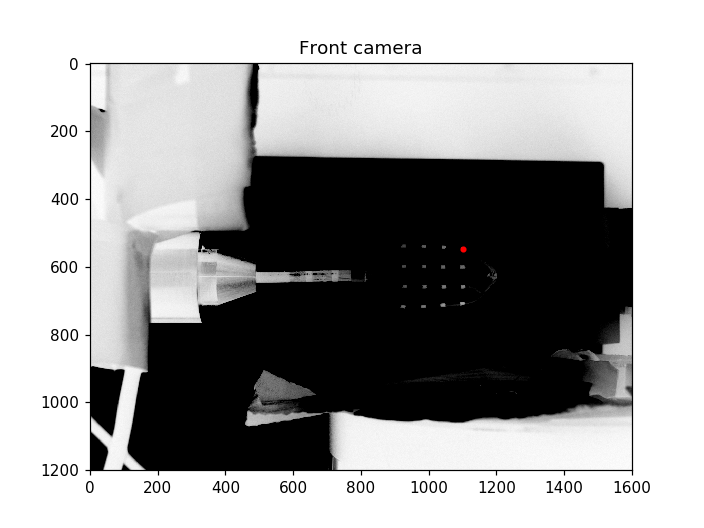

In [13]:
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data\\Sample69_Runs3to10\\Run 7')

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

front_im = mpimg.imread('Front\\Front933_20180313042256.bmp') 
front_plot = plt.imshow(front_im)
front_plot.set_cmap('gray')
front_caldots = plt.plot(front_pix[0],front_pix[1],'r.')
plt.title('Front camera')

<IPython.core.display.Javascript object>


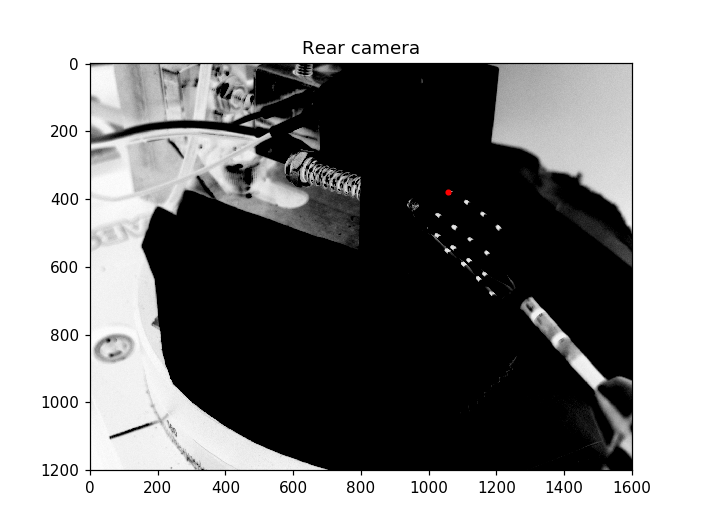

In [14]:
#os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data\\Sample56_Runs8to9\\Run 9')
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rear_im = mpimg.imread('Rear\\Rear999_20180313043621.bmp')
rear_plot = plt.imshow(rear_im)
rear_plot.set_cmap('gray')
rear_caldots = plt.plot(rear_pix[0],rear_pix[1],'r.')
plt.title('Rear camera')

<IPython.core.display.Javascript object>


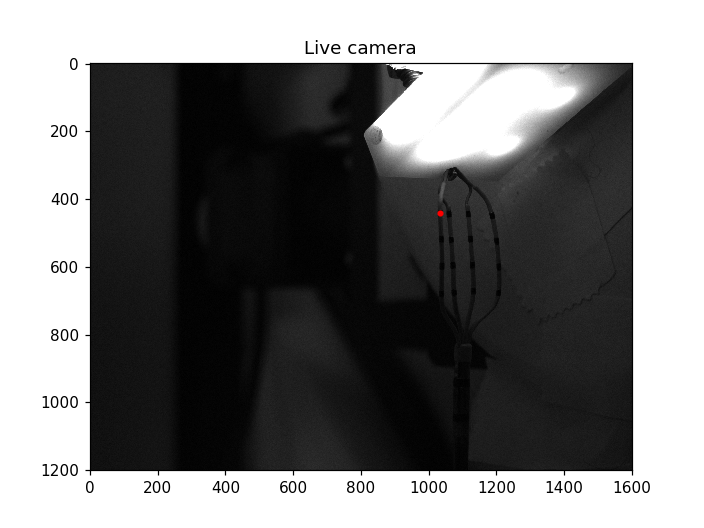

In [15]:
#os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data\\Sample56_Runs8to9\\Run 9')
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Live_im = mpimg.imread('Live\\Live780_20180313041918.bmp')
Live_plot = plt.imshow(Live_im)
Live_plot.set_cmap('gray')
Live_caldots = plt.plot(live_pix[0],live_pix[1],'r.')

plt.title('Live camera')

# Copy Files from Local Drive onto Q Drive

In [44]:
#copy files from local drive onto Q drive
import shutil
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data')
filename= 'ProcRun3D_WithLive.csv' #name of file to be copied
copyTo= "Q:\\AF R&D\\AR&T Active Projects\\Hybrid localization\\Design\Mechanical modeling\\Advisor HD\\3 Cams data"
count=0
for root, dirs, files in os.walk("."): 
    if 'ProcRun3D_WithLive.csv' in files:
        sampleNum= root[8:10] #sample number
        splitRoot= root.split('Run') 
        runNum= int(str(splitRoot[2]))#run number
        copyToFolder= 'Sample{}_Run{}'.format(sampleNum,runNum) #Name of folder to copy to
        copyToDir= os.path.join(copyTo, copyToFolder)
        copyFromDir= os.path.join(root, filename)
        if os.path.isdir(copyToDir):
            shutil.copy2(copyFromDir,copyToDir)
            count=count+1
            print(copyToFolder)
            #if count==20: break
print('done! {} files were copied'.format(count))

IndexError: list index out of range

In [27]:
#copy files from local drive onto Q drive
import shutil
import distutils
from distutils import dir_util
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data')
foldername= 'ProjectedImages' #name of file to be copied
copyTo= "Q:\\AF R&D\\AR&T Active Projects\\Hybrid localization\\Design\Mechanical modeling\\Advisor HD\\3 Cams data"
count=0
for root, dirs, files in os.walk("."): 
    if 'ProjectedImages' in os.listdir(root):
        sampleNum= root[8:10] #sample number
        splitRoot= root.split('Run') 
        runNum= int(str(splitRoot[2]))#run number
        copyToFolder= 'Sample{}_Run{}'.format(sampleNum,runNum) #Name of folder to copy to
        copyToRoot= os.path.join(copyTo, copyToFolder)
        copyToDir= os.path.join(copyToRoot,foldername)
        copyFromDir= os.path.join(root, foldername)
        if os.path.isdir(copyToRoot):
            #shutil.copytree(copyFromDir,copyToDir)
            if not os.path.exists(copyToDir):
                os.makedirs(copyToDir)
            else: continue
            distutils.dir_util.copy_tree(copyFromDir,copyToDir)
            count=count+1
            print(copyToFolder)
            #if count==20: break
print('done! {} files were copied'.format(count))

Q:\AF R&D\AR&T Active Projects\Hybrid localization\Design\Mechanical modeling\Advisor HD\3 Cams data\Sample16_Run15\ProjectedImages
Q:\AF R&D\AR&T Active Projects\Hybrid localization\Design\Mechanical modeling\Advisor HD\3 Cams data\Sample16_Run16\ProjectedImages
Sample16_Run16
Q:\AF R&D\AR&T Active Projects\Hybrid localization\Design\Mechanical modeling\Advisor HD\3 Cams data\Sample16_Run17\ProjectedImages
Sample16_Run17
Q:\AF R&D\AR&T Active Projects\Hybrid localization\Design\Mechanical modeling\Advisor HD\3 Cams data\Sample16_Run18\ProjectedImages
Sample16_Run18
Q:\AF R&D\AR&T Active Projects\Hybrid localization\Design\Mechanical modeling\Advisor HD\3 Cams data\Sample16_Run19\ProjectedImages
Sample16_Run19
Q:\AF R&D\AR&T Active Projects\Hybrid localization\Design\Mechanical modeling\Advisor HD\3 Cams data\Sample16_Run20\ProjectedImages
Sample16_Run20
Q:\AF R&D\AR&T Active Projects\Hybrid localization\Design\Mechanical modeling\Advisor HD\3 Cams data\Sample16_Run21\ProjectedImages
S

KeyboardInterrupt: 

# DON'T EXECUTE BOX BELOW UNLESS YOU WANT TO DELETE CERTAIN FILES

In [ ]:
#DON'T EXECUTE THIS! only execute when need to delete certain files
#deleting certain files
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data')
filename= 'ProcRun3D_TopRear.csv' #name of file to be deleted
for root, dirs, files in os.walk("."): 
    if filename in files:
        print(root)
        os.remove(os.path.join(root, filename))
        #os.rmdir(os.path.join(root, 'ProcRun3D_TopRear.csv'))
print('done!')

# DON'T' EXECUTE BOX BELOW UNLESS YOU WANT TO CHANGE FILENAMES

In [69]:
oldName= 'ProcRun3D.csv'
newName= 'ProcRun3D_old2.csv'
os.chdir('C:\\Users\\HoangT04\\Documents\\deform\\HD_data')
for root, dirs, files in os.walk('.'):
    if oldName in files:
        curdir= os.getcwd() #get current directory
        filename= os.path.join(root, oldName) #location of old file name
        newfilename= os.path.join(root, newName) #location of new file name
        os.rename (filename,newfilename) #change old names to new names
        print(root)
print('done!')

.\Sample49_Runs1to2\Run 1
.\Sample49_Runs1to2\Run 2
.\Sample49_Runs3to4\Run 3
.\Sample49_Runs3to4\Run 4
.\Sample55_Runs1to3\Run 1
.\Sample55_Runs1to3\Run 2
.\Sample55_Runs1to3\Run 3
.\Sample56_Runs4
.\Sample56_Runs5to7\Run 5
.\Sample56_Runs5to7\Run 6
.\Sample56_Runs5to7\Run 7
.\Sample56_Runs8to9\Run 8
.\Sample56_Runs8to9\Run 9
.\Sample58_Runs1to3\Run 1
.\Sample58_Runs1to3\Run 2
.\Sample58_Runs1to3\Run 3
.\Sample60_Runs11to12\Run 11
.\Sample60_Runs11to12\Run 12
.\Sample60_Runs13\Run 13
.\Sample60_Runs1to2\Run 1
.\Sample60_Runs1to2\Run 2
.\Sample60_Runs3to4\Run 3
.\Sample60_Runs3to4\Run 4
.\Sample60_Runs5to6\Run 5
.\Sample60_Runs5to6\Run 6
.\Sample60_Runs7to8\Run 7
.\Sample60_Runs7to8\Run 8
.\Sample60_Runs9to10\Run 10
.\Sample60_Runs9to10\Run 9
.\Sample65_Runs11to18\Run 11
.\Sample65_Runs11to18\Run 12
.\Sample65_Runs11to18\Run 13
.\Sample65_Runs11to18\Run 14
.\Sample65_Runs11to18\Run 15
.\Sample65_Runs11to18\Run 17
.\Sample65_Runs11to18\Run 18
.\Sample65_Runs1to7\Run 1
.\Sample65_Runs1to